In [1]:
""" 2017.07.19
made by changsub Bae
github.com/windowsub0406
"""
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
# from src import parseTrackletXML as pt_XML

class Kitti:

    """
    frame : specific frame number or 'all' for whole dataset. default = 'all'
    velo_path : velodyne bin file path. default = None
    camera_path : left-camera image file path. default = None
    img_type : image type info 'gray' or 'color'. default = 'gray'
    v2c_path : Velodyne to Camera calibration info file path. default = None
    c2c_path : camera to Camera calibration info file path. default = None
    xml_path : XML file having tracklet info
    """
    def __init__(self, frame='all', velo_path=None, camera_path=None, \
                 img_type='gray', v2c_path=None, c2c_path=None, xml_path=None):
        self.__frame_type = frame
        self.__img_type = img_type
        self.__num_frames = None
        self.__cur_frame = None

        if velo_path is not None:
            self.__velo_path = velo_path
            self.__velo_file = self.__load_from_bin()
        else:
            self.__velo_path, self.__velo_file = None, None

        if camera_path is not None:
            self.__camera_path = camera_path
            self.__camera_file = self.__load_image()
        else:
            self.__camera_path, self.__camera_file = None, None
        if v2c_path is not None:
            self.__v2c_path = v2c_path
            self.__v2c_file = self.__load_velo2cam()
        else:
            self.__v2c_path, self.__v2c_file = None, None
        if c2c_path is not None:
            self.__c2c_path = c2c_path
            self.__c2c_file = self.__load_cam2cam()
        else:
            self.__c2c_path, self.__c2c_file = None, None
        if xml_path is not None:
            self.__xml_path = xml_path
            self.__tracklet_box, self.__tracklet_type = self.__load_tracklet()
        else:
            self.__xml_path = None
            self.__tracklet_box, self.__tracklet_type = None, None

    @property
    def frame_type(self):
        return self.__frame_type

    @property
    def image_type(self):
        return self.__img_type

    @property
    def num_frame(self):
        return self.__num_frames

    @property
    def cur_frame(self):
        return self.__cur_frame

    @property
    def img_size(self):
        return self.__img_size

    @property
    def velo_file(self):
        return self.__velo_file

    @property
    def velo_d_file(self):
        x = self.__velo_file[:, 0]
        y = self.__velo_file[:, 1]
        z = self.__velo_file[:, 2]
        d = np.sqrt(x ** 2 + y ** 2 + z ** 2)
        return np.hstack((self.__velo_file, d[:, None]))

    @property
    def camera_file(self):
        return self.__camera_file

    @property
    def v2c_file(self):
        return self.__v2c_file

    @property
    def c2c_file(self):
        return self.__c2c_file

    @property
    def tracklet_info(self):
        return self.__tracklet_box, self.__tracklet_type

    def __get_velo(self, files):
        """ Convert bin to numpy array for whole dataset"""

        for i in files.keys():
            points = np.fromfile(files[i], dtype=np.float32).reshape(-1, 4)
            self.__velo_file = points[:, :3]
            self.__cur_frame = i
            yield self.__velo_file

    def __get_velo_frame(self, files):
        """ Convert bin to numpy array for one frame """
        points = np.fromfile(files[self.__frame_type], dtype=np.float32).reshape(-1, 4)
        return points[:, :3]

    def __get_camera(self, files):
        """ Return image for whole dataset """

        for i in files.keys():
            self.__camera_file = files[i]
            self.__cur_frame = i
            frame = cv2.imread(self.__camera_file)
            if i == 0:
                self.__img_size = frame.shape
            yield frame

    def __get_camera_frame(self, files):
        """ Return image for one frame """
        frame = cv2.imread(files[self.__frame_type])
        self.__img_size = frame.shape
        return frame

    def __load_from_bin(self):
        """ Return numpy array including velodyne's all 3d x,y,z point cloud """
        velo_bins = glob.glob(self.__velo_path + '/*.bin')
        velo_bins.sort()
        self.__num_frames = len(velo_bins)
        velo_files = {i: velo_bins[i] for i in range(len(velo_bins))}
#         if self.__frame_type in velo_files:
        velo_xyz = self.__get_velo_frame(velo_files)
#         else:
#         velo_xyz = self.__get_velo(velo_files)

        return velo_xyz

    def __load_image(self):
        """ Return camera image """

        image_path = glob.glob(self.__camera_path + '/*.png')
        image_path.sort()
        self.__num_frames = len(image_path)
        image_files = {i: image_path[i] for i in range(len(image_path))}

        if self.__frame_type in image_files:
            image = self.__get_camera_frame(image_files)
        else:
            image = self.__get_camera(image_files)

        return image

    def __load_velo2cam(self):
        """ load Velodyne to Camera calibration info file """
        with open(self.__v2c_path, "r") as f:
            file = f.readlines()
            return file

    def __load_cam2cam(self):
        """ load Camera to Camera calibration info file """
        with open(self.__c2c_path, "r") as f:
            file = f.readlines()
            return file

    def __load_tracklet(self):
        """ extract tracklet's 3d box points and type """

        # read info from xml file
        tracklets = pt_XML.parseXML(self.__xml_path)

        f_tracklet = {}
        f_type = {}

        # refered to parseTrackletXML.py's example function
        # loop over tracklets
        for tracklet in tracklets:

            # this part is inspired by kitti object development kit matlab code: computeBox3D
            h, w, l = tracklet.size
            trackletBox = np.array([  # in velodyne coordinates around zero point and without orientation yet\
                [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2], \
                [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2], \
                [0.0, 0.0, 0.0, 0.0, h, h, h, h]])

            # loop over all data in tracklet
            for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in tracklet:

                # determine if object is in the image; otherwise continue
                if truncation not in (pt_XML.TRUNC_IN_IMAGE, pt_XML.TRUNC_TRUNCATED):
                    continue

                # re-create 3D bounding box in velodyne coordinate system
                yaw = rotation[2]  # other rotations are 0 in all xml files I checked
                assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
                rotMat = np.array([ \
                    [np.cos(yaw), -np.sin(yaw), 0.0], \
                    [np.sin(yaw), np.cos(yaw), 0.0], \
                    [0.0, 0.0, 1.0]])

                cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T

                if absoluteFrameNumber in f_tracklet:
                    f_tracklet[absoluteFrameNumber] += [cornerPosInVelo]
                    f_type[absoluteFrameNumber] += [tracklet.objectType]
                else:
                    f_tracklet[absoluteFrameNumber] = [cornerPosInVelo]
                    f_type[absoluteFrameNumber] = [tracklet.objectType]

        # fill none in non object frame
        if self.num_frame is not None:
            for i in range(self.num_frame):
                if i not in f_tracklet:
                    f_tracklet[i] = None
                    f_type[i] = None

        return f_tracklet, f_type

    def __del__(self):
        pass

class Kitti_util(Kitti):

    def __init__(self, frame='all', velo_path=None, camera_path=None, \
                 img_type='gray', v2c_path=None, c2c_path=None, xml_path=None, t_cor=None, r_cor=None):
        super(Kitti_util, self).__init__(frame, velo_path, camera_path, img_type, v2c_path, c2c_path, xml_path)
        self.__h_min, self.__h_max = -180, 180
        self.__v_min, self.__v_max = -24.9, 2.0
        self.__v_res, self.__h_res = 0.42, 0.35
        self.__x, self.__y, self.__z, self.__d = None, None, None, None
        self.__h_fov, self.__v_fov = None, None
        self.__x_range, self.__y_range, self.__z_range = None, None, None
        self.__get_sur_size, self.__get_top_size = None, None
        
        self.t_cor = t_cor
        self.r_cor = r_cor

    @property
    def surround_size(self):
        return self.__get_sur_size

    @property
    def topview_size(self):
        return self.__get_top_size

    def __calib_velo2cam(self):
        """
        get Rotation(R : 3x3), Translation(T : 3x1) matrix info
        using R,T matrix, we can convert velodyne coordinates to camera coordinates
        """
        if self.v2c_file is None:
            raise NameError("calib_velo_to_cam file isn't loaded.")

        for line in self.v2c_file:
            (key, val) = line.split(':', 1)
            if key == 'R':
                R = np.fromstring(val, sep=' ')
                R = R.reshape(3, 3)
                if self.r_cor is not None:
                    R = R + np.diag(self.r_cor)
            if key == 'T':
                T = np.fromstring(val, sep=' ')
                T = T.reshape(3, 1)
                if self.t_cor is not None:
                    T = T + self.t_cor.reshape((3, 1))
        return R, T

    def __calib_cam2cam(self):
        """
        If your image is 'rectified image' :
            get only Projection(P : 3x4) matrix is enough
        but if your image is 'distorted image'(not rectified image) :
            you need undistortion step using distortion coefficients(5 : D)
        In this code, only P matrix info is used for rectified image
        """
        if self.c2c_file is None:
            raise NameError("calib_velo_to_cam file isn't loaded.")

        mode = '00' if self.image_type == 'gray' else '02'

        for line in self.c2c_file:
            (key, val) = line.split(':', 1)
            if key == ('P_rect_' + mode):
                P_ = np.fromstring(val, sep=' ')
                P_ = P_.reshape(3, 4)
                # erase 4th column ([0,0,0])
                P_ = P_[:3, :3]
        return P_

    def __upload_points(self, points):
        self.__x = points[:, 0]
        self.__y = points[:, 1]
        self.__z = points[:, 2]
        self.__d = np.sqrt(self.__x ** 2 + self.__y ** 2 + self.__z ** 2)

    def __point_matrix(self, points):
        """ extract points corresponding to FOV setting """

        # filter in range points based on fov, x,y,z range setting
        self.__points_filter(points)

        # Stack arrays in sequence horizontally
        xyz_ = np.hstack((self.__x[:, None], self.__y[:, None], self.__z[:, None]))
        xyz_ = xyz_.T

        # stack (1,n) arrays filled with the number 1
        one_mat = np.full((1, xyz_.shape[1]), 1)
        xyz_ = np.concatenate((xyz_, one_mat), axis=0)

        # need dist info for points color
        color = self.__normalize_data(self.__d, min=1, max=70, scale=120, clip=True)

        return xyz_, color

    def __normalize_data(self, val, min, max, scale, depth=False, clip=False):
        """ Return normalized data """
        if clip:
            # limit the values in an array
            np.clip(val, min, max, out=val)
        if depth:
            """
            print 'normalized depth value'
            normalize values to (0 - scale) & close distance value has high value. (similar to stereo vision's disparity map)
            """
            return (((max - val) / (max - min)) * scale).astype(np.uint8)
        else:
            """
            print 'normalized value'
            normalize values to (0 - scale) & close distance value has low value.
            """
            return (((val - min) / (max - min)) * scale).astype(np.uint8)

    def __hv_in_range(self, m, n, fov, fov_type='h'):
        """ extract filtered in-range velodyne coordinates based on azimuth & elevation angle limit 
            horizontal limit = azimuth angle limit
            vertical limit = elevation angle limit
        """

        if fov_type == 'h':
            return np.logical_and(np.arctan2(n, m) > (-fov[1] * np.pi / 180), \
                                  np.arctan2(n, m) < (-fov[0] * np.pi / 180))
        elif fov_type == 'v':
            return np.logical_and(np.arctan2(n, m) < (fov[1] * np.pi / 180), \
                                  np.arctan2(n, m) > (fov[0] * np.pi / 180))
        else:
            raise NameError("fov type must be set between 'h' and 'v' ")

    def __3d_in_range(self, points):
        """ extract filtered in-range velodyne coordinates based on x,y,z limit """
        return points[np.logical_and.reduce((self.__x > self.__x_range[0], self.__x < self.__x_range[1], \
                                             self.__y > self.__y_range[0], self.__y < self.__y_range[1], \
                                             self.__z > self.__z_range[0], self.__z < self.__z_range[1]))]

    def __points_filter(self, points):
        """
        filter points based on h,v FOV and x,y,z distance range.
        x,y,z direction is based on velodyne coordinates
        1. azimuth & elevation angle limit check
        2. x,y,z distance limit
        """

        # upload current points
        self.__upload_points(points)

        x, y, z = points[:, 0], points[:, 1], points[:, 2]
        d = np.sqrt(x ** 2 + y ** 2 + z ** 2)

        if self.__h_fov is not None and self.__v_fov is not None:
            if self.__h_fov[1] == self.__h_max and self.__h_fov[0] == self.__h_min and \
                            self.__v_fov[1] == self.__v_max and self.__v_fov[0] == self.__v_min:
                pass
            elif self.__h_fov[1] == self.__h_max and self.__h_fov[0] == self.__h_min:
                con = self.__hv_in_range(d, z, self.__v_fov, fov_type='v')
                lim_x, lim_y, lim_z, lim_d = self.__x[con], self.__y[con], self.__z[con], self.__d[con]
                self.__x, self.__y, self.__z, self.__d = lim_x, lim_y, lim_z, lim_d
            elif self.__v_fov[1] == self.__v_max and self.__v_fov[0] == self.__v_min:
                con = self.__hv_in_range(x, y, self.__h_fov, fov_type='h')
                lim_x, lim_y, lim_z, lim_d = self.__x[con], self.__y[con], self.__z[con], self.__d[con]
                self.__x, self.__y, self.__z, self.__d = lim_x, lim_y, lim_z, lim_d
            else:
                h_points = self.__hv_in_range(x, y, self.__h_fov, fov_type='h')
                v_points = self.__hv_in_range(d, z, self.__v_fov, fov_type='v')
                con = np.logical_and(h_points, v_points)
                lim_x, lim_y, lim_z, lim_d = self.__x[con], self.__y[con], self.__z[con], self.__d[con]
                self.__x, self.__y, self.__z, self.__d = lim_x, lim_y, lim_z, lim_d
        else:
            pass

        if self.__x_range is None and self.__y_range is None and self.__z_range is None:
            pass
        elif self.__x_range is not None and self.__y_range is not None and self.__z_range is not None:
            # extract in-range points
            temp_x, temp_y = self.__3d_in_range(self.__x), self.__3d_in_range(self.__y)
            temp_z, temp_d = self.__3d_in_range(self.__z), self.__3d_in_range(self.__d)
            self.__x, self.__y, self.__z, self.__d = temp_x, temp_y, temp_z, temp_d
        else:
            raise ValueError("Please input x,y,z's min, max range(m) based on velodyne coordinates. ")

    def __surround_view(self, points, depth):
        """ convert coordinates for panoramic image """

        # upload current points
        self.__points_filter(points)
        # project point cloud to 2D point map
        x_img = np.arctan2(-self.__y, self.__x) / (self.__h_res * (np.pi / 180))
        y_img = -(np.arctan2(self.__z, self.__d) / (self.__v_res * (np.pi / 180)))
        # filter in range points based on fov, x,y,z range setting

        x_size = int(np.ceil((self.__h_fov[1] - self.__h_fov[0]) / self.__h_res))
        y_size = int(np.ceil((self.__v_fov[1] - self.__v_fov[0]) / self.__v_res))
        self.__get_sur_size = (x_size + 1, y_size + 1)

        # shift negative points to positive points (shift minimum value to 0)
        x_offset = self.__h_fov[0] / self.__h_res
        x_img = np.trunc(x_img - x_offset).astype(np.int32)
        y_offset = self.__v_fov[1] / self.__v_res
        y_fine_tune = 1
        y_img = np.trunc(y_img + y_offset + y_fine_tune).astype(np.int32)
        dist = self.__normalize_data(self.__d, min=0, max=120, scale=255, depth=depth)

        # array to img
        img = np.zeros([y_size + 1, x_size + 1], dtype=np.uint8)
        img[y_img, x_img] = dist
        return img

    def __topview(self, points, scale):
        """ convert coordinates for top-view (bird's eye view) image """

        # filter in range points based on fov, x,y,z range setting
        self.__points_filter(points)

        x_size = int(np.ceil(self.__y_range[1] - self.__y_range[0]))
        y_size = int(np.ceil(self.__x_range[1] - self.__x_range[0]))
        self.__get_sur_size = (x_size * scale + 1, y_size * scale + 1)

        # convert 3D lidar coordinates(vehicle coordinates) to 2D image coordinates
        # Velodyne coordinates info : http://www.cvlibs.net/publications/Geiger2013IJRR.pdf
        # scale - for high resolution
        x_img = -(self.__y * scale).astype(np.int32)
        y_img = -(self.__x * scale).astype(np.int32)

        # shift negative points to positive points (shift minimum value to 0)
        x_img += int(np.trunc(self.__y_range[1] * scale))
        y_img += int(np.trunc(self.__x_range[1] * scale))

        # normalize distance value & convert to depth map
        max_dist = np.sqrt((max(self.__x_range) ** 2) + (max(self.__y_range) ** 2))
        dist_lim = self.__normalize_data(self.__d, min=0, max=max_dist, scale=255, depth=True)
        # array to img
        img = np.zeros([y_size * scale + 1, x_size * scale + 1], dtype=np.uint8)
        img[y_img, x_img] = dist_lim
        return img

    def __velo_2_img_projection(self, points):
        """ convert velodyne coordinates to camera image coordinates """

        # rough velodyne azimuth range corresponding to camera horizontal fov
        if self.__h_fov is None:
            self.__h_fov = (-50, 50)
        if self.__h_fov[0] < -50:
            self.__h_fov = (-50,) + self.__h_fov[1:]
        if self.__h_fov[1] > 50:
            self.__h_fov = self.__h_fov[:1] + (50,)

        # R_vc = Rotation matrix ( velodyne -> camera )
        # T_vc = Translation matrix ( velodyne -> camera )
        R_vc, T_vc = self.__calib_velo2cam()

        # P_ = Projection matrix ( camera coordinates 3d points -> image plane 2d points )
        P_ = self.__calib_cam2cam()

        """
        xyz_v - 3D velodyne points corresponding to h, v FOV limit in the velodyne coordinates
        c_    - color value(HSV's Hue vaule) corresponding to distance(m)
                 [x_1 , x_2 , .. ]
        xyz_v =  [y_1 , y_2 , .. ]
                 [z_1 , z_2 , .. ]
                 [ 1  ,  1  , .. ]
        """
        xyz_v, c_ = self.__point_matrix(points)

        """
        RT_ - rotation matrix & translation matrix
            ( velodyne coordinates -> camera coordinates )
                [r_11 , r_12 , r_13 , t_x ]
        RT_  =  [r_21 , r_22 , r_23 , t_y ]
                [r_31 , r_32 , r_33 , t_z ]
        """
        RT_ = np.concatenate((R_vc, T_vc), axis=1)

        # convert velodyne coordinates(X_v, Y_v, Z_v) to camera coordinates(X_c, Y_c, Z_c)
        for i in range(xyz_v.shape[1]):
            xyz_v[:3, i] = np.matmul(RT_, xyz_v[:, i])

        """
        xyz_c - 3D velodyne points corresponding to h, v FOV in the camera coordinates
                 [x_1 , x_2 , .. ]
        xyz_c =  [y_1 , y_2 , .. ]
                 [z_1 , z_2 , .. ]
        """
        xyz_c = np.delete(xyz_v, 3, axis=0)

        # convert camera coordinates(X_c, Y_c, Z_c) image(pixel) coordinates(x,y)
        for i in range(xyz_c.shape[1]):
            xyz_c[:, i] = np.matmul(P_, xyz_c[:, i])

        """
        xy_i - 3D velodyne points corresponding to h, v FOV in the image(pixel) coordinates before scale adjustment
        ans  - 3D velodyne points corresponding to h, v FOV in the image(pixel) coordinates
                 [s_1*x_1 , s_2*x_2 , .. ]
        xy_i =   [s_1*y_1 , s_2*y_2 , .. ]        ans =   [x_1 , x_2 , .. ]
                 [  s_1   ,   s_2   , .. ]                [y_1 , y_2 , .. ]
        """
        xy_i = xyz_c[::] / xyz_c[::][2]
        ans = np.delete(xy_i, 2, axis=0)

        return ans, c_

    def velo_2_pano(self, h_fov=None, v_fov=None, x_range=None, y_range=None, z_range=None, depth=False):
        """ panoramic image for whole velo dataset """

        self.__v_fov, self.__h_fov = v_fov, h_fov
        self.__x_range, self.__y_range, self.__z_range = x_range, y_range, z_range

        velo_gen = self.velo_file
        if velo_gen is None:
            raise ValueError("Velo data is not included in this class")
        for points in velo_gen:
            res = self.__surround_view(points, depth)
            yield res

    def velo_2_pano_frame(self, h_fov=None, v_fov=None, x_range=None, y_range=None, z_range=None, depth=False):
        """ panoramic image for one frame """

        self.__v_fov, self.__h_fov = v_fov, h_fov
        self.__x_range, self.__y_range, self.__z_range = x_range, y_range, z_range

        velo_gen = self.velo_file
        if velo_gen is None:
            raise ValueError("Velo data is not included in this class")
        res = self.__surround_view(velo_gen, depth)
        return res

    def velo_2_topview(self, h_fov=None, v_fov=None, x_range=None, y_range=None, z_range=None, scale=10):
        """ Top-view(Bird's eye view) image for whole velo dataset """

        self.__v_fov, self.__h_fov = v_fov, h_fov
        self.__x_range, self.__y_range, self.__z_range = x_range, y_range, z_range

        if scale <= 0:
            raise ValueError("scale value must be positive. default value is 10.")
        elif float(scale).is_integer() is False:
            scale = round(scale)

        velo_gen = self.velo_file
        if velo_gen is None:
            raise ValueError("Velo data is not included in this class")
        for points in velo_gen:
            res = self.__topview(points, scale)
            yield res

    def velo_2_topview_frame(self, h_fov=None, v_fov=None, x_range=None, y_range=None, z_range=None, scale=10):
        """ Top-view(Bird's eye view) image for one frame """
        self.__v_fov, self.__h_fov = v_fov, h_fov
        self.__x_range, self.__y_range, self.__z_range = x_range, y_range, z_range

        if scale <= 0:
            raise ValueError("scale value must be positive. default value is 10.")
        elif float(scale).is_integer() is False:
            scale = round(scale)

        velo_gen = self.velo_file
        if velo_gen is None:
            raise ValueError("Velo data is not included in this class")
        res = self.__topview(velo_gen, scale)
        return res

    def velo_projection(self, h_fov=None, v_fov=None, x_range=None, y_range=None, z_range=None):
        """ print velodyne 3D points corresponding to camera 2D image """

        self.__v_fov, self.__h_fov = v_fov, h_fov
        self.__x_range, self.__y_range, self.__z_range = x_range, y_range, z_range
        velo_gen, cam_gen = self.velo_file, self.camera_file

        if velo_gen is None:
            raise ValueError("Velo data is not included in this class")
        if cam_gen is None:
            raise ValueError("Cam data is not included in this class")
        for frame, points in zip(cam_gen, velo_gen):
            res, c_ = self.__velo_2_img_projection(points)
            yield [frame, res, c_]

    def velo_projection_frame(self, h_fov=None, v_fov=None, x_range=None, y_range=None, z_range=None):
        """ print velodyne 3D points corresponding to camera 2D image """

        self.__v_fov, self.__h_fov = v_fov, h_fov
        self.__x_range, self.__y_range, self.__z_range = x_range, y_range, z_range
        velo_gen, cam_gen = self.velo_file, self.camera_file

        if velo_gen is None:
            raise ValueError("Velo data is not included in this class")
        if cam_gen is None:
            raise ValueError("Cam data is not included in this class")
        res, c_ = self.__velo_2_img_projection(velo_gen)
        return cam_gen, res, c_, self.__d

    def __del__(self):
        pass
 
def print_projection_cv2(points, color, image):
    """ project converted velodyne points into camera image """
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]), np.int32(points[1][i])), 2, (np.int(color[i]), 255, 255), -1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

def print_projection_plt(points, color, image):
    """ project converted velodyne points into camera image """
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (int(points[0][i]), int(points[1][i])), 2, (int(color[i]), 255, 255), -1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

def pano_example1():
    """ save one frame image about velodyne dataset converted to panoramic image  """
    velo_path = './velodyne_points/data'
    v_fov, h_fov = (-10.5, 2.0), (-60, 80)
    velo = Kitti_util(frame=89, velo_path=velo_path)

    frame = velo.velo_2_pano_frame(h_fov, v_fov, depth=False)

    cv2.imshow('panoramic result', frame)
    cv2.waitKey(0)

def pano_example2():
    """ save video about velodyne dataset converted to panoramic image  """
    velo_path = './velodyne_points/data'
    v_fov, h_fov = (-24.9, 2.0), (-180, 160)

    velo2 = Kitti_util(frame='all', velo_path=velo_path)
    pano = velo2.velo_2_pano(h_fov, v_fov, depth=False)

    velo = Kitti_util(frame=0, velo_path=velo_path)
    velo.velo_2_pano_frame(h_fov, v_fov, depth=False)
    size = velo.surround_size

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    vid = cv2.VideoWriter('pano_result.avi', fourcc, 25.0, size, False)

    for frame in pano:
        vid.write(frame)

    print('video saved')
    vid.release()

def topview_example1():
    """ save one frame image about velodyne dataset converted to topview image  """
    velo_path = './velodyne_points/data'
    x_range, y_range, z_range = (-15, 15), (-10, 10), (-2, 2)
    velo = Kitti_util(frame=89, velo_path=velo_path)

    frame = velo.velo_2_topview_frame(x_range=x_range, y_range=y_range, z_range=z_range)

    cv2.imshow('panoramic result', frame)
    cv2.waitKey(0)

def topview_example2():
    """ save video about velodyne dataset converted to topview image  """
    velo_path = './velodyne_points/data'
    x_range, y_range, z_range, scale = (-20, 20), (-20, 20), (-2, 2), 10
    size = (int((max(y_range) - min(y_range)) * scale), int((max(x_range) - min(x_range)) * scale))

    velo2 = Kitti_util(frame='all', velo_path=velo_path)
    topview = velo2.velo_2_topview(x_range=x_range, y_range=y_range, z_range=z_range, scale=scale)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    vid = cv2.VideoWriter('topview_result.avi', fourcc, 25.0, size, False)

    for frame in topview:
        vid.write(frame)

    print('video saved')
    vid.release()

def project(img_path, calib_path, frame=89, t_cor=np.zeros((3, 1)), r_cor=np.zeros((3, 1))):
    """ save one frame about projecting velodyne points into camera image """
    image_type = 'gray'  # 'gray' or 'color' image
    mode = '00' if image_type == 'gray' else '02'  # image_00 = 'graye image' , image_02 = 'color image'

    image_path = img_path + 'image_' + mode + '/data'
    velo_path = img_path + 'velodyne_points/data'

    v_fov, h_fov = (-24.9, 2.0), (-90, 90)

    v2c_filepath = calib_path + 'calib_velo_to_cam.txt'
    c2c_filepath = calib_path + 'calib_cam_to_cam.txt'

    res = Kitti_util(frame=frame, camera_path=image_path, velo_path=velo_path, \
                    v2c_path=v2c_filepath, c2c_path=c2c_filepath, t_cor=t_cor, r_cor=r_cor)

    img, pnt, c_, depth = res.velo_projection_frame(v_fov=v_fov, h_fov=h_fov)

    result = print_projection_cv2(pnt, c_, img)
    return img, pnt, result, depth

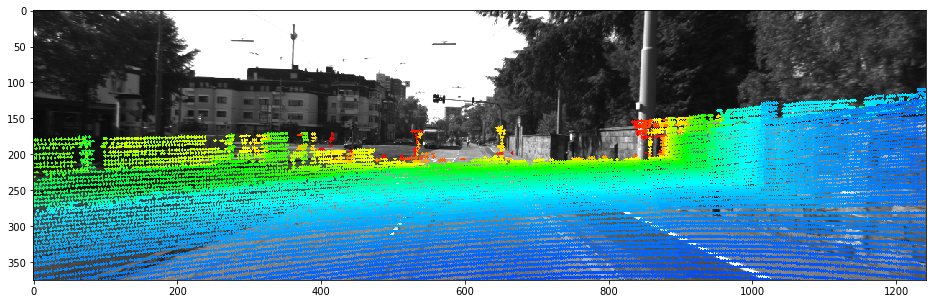

In [2]:
img, pnt, proj, depth = project('2011_09_26/2011_09_26_drive_0002_sync/', '2011_09_26/', frame=59, r_cor=np.array([.3, .05, 0]), t_cor=np.array([-1.1, 0, 0]))
f = plt.figure(figsize=(16, 12))
plt.imshow(proj);

In [111]:
pnt.T.shape, depth.shape

((34220, 2), (34220,))

In [96]:
h, w, c = img.shape
dimg = np.zeros((h, w))

In [97]:
pnt.T

array([[480.16388856, 155.37219268],
       [477.73306605, 155.35364201],
       [475.33550391, 155.43021413],
       ...,
       [881.59222634, 455.30088964],
       [879.18307883, 454.93944322],
       [876.69189581, 454.78387107]])

In [98]:
def inpaint(points, color, image):
    """ project converted velodyne points into camera image """
    image = np.copy(image)
    for i in range(points.shape[1]):
        cv2.circle(image, (int(points[0][i]), int(points[1][i])), 7, (int(color[i].round()), 0, 0), -1)

    return image

In [99]:
reliable_xy = pnt.round().astype(int).T
img_idx = np.where((reliable_xy[:, 0] >= 0) & (reliable_xy[:, 0] < w) & (reliable_xy[:, 1] >= 0) & (reliable_xy[:, 1] < h))
img_xy = reliable_xy[img_idx]

In [100]:
#r.T[img_xy[:, 0], img_xy[:, 1]]
img_xy

array([[480, 155],
       [478, 155],
       [475, 155],
       ...,
       [632, 373],
       [630, 373],
       [628, 373]])

In [101]:
r = inpaint(pnt, depth, dimg)

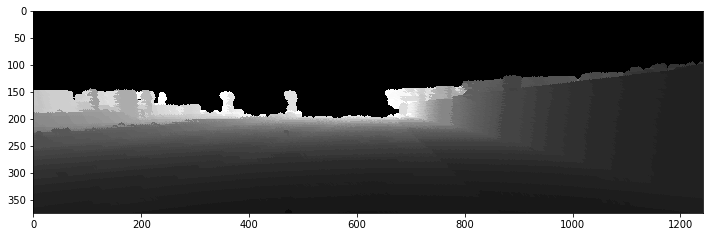

In [102]:
plt.figure(figsize=(12, 10))
plt.imshow(r, cmap=plt.cm.Greys_r);

In [103]:
from scipy.ndimage import sobel

In [104]:
def edges(img):
    dx = sobel(img, axis=0, mode='constant')
    dy = sobel(img, axis=1, mode='constant')
    sob = np.hypot(dx, dy)
    return dx, dy, sob

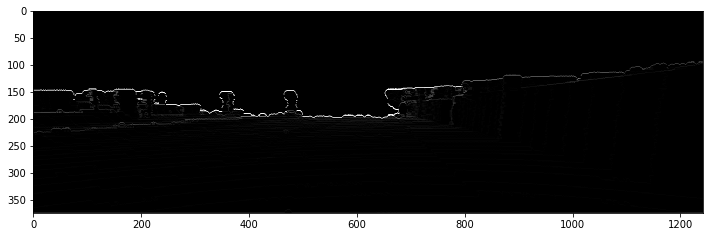

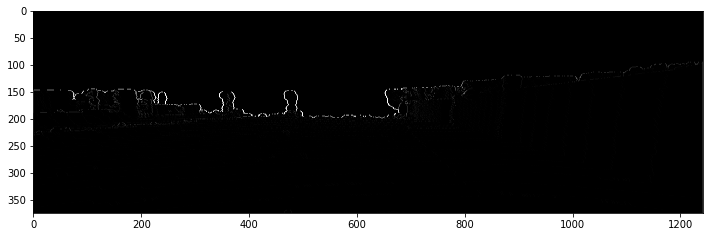

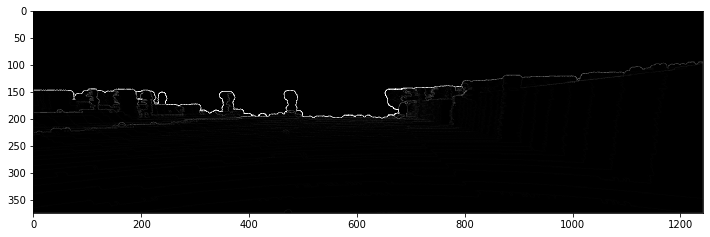

In [109]:
plt.figure(figsize=(12, 10))

dx, dy, sob = edges(r)
plt.imshow(np.abs(dx), cmap=plt.cm.Greys_r)
plt.show();
plt.figure(figsize=(12, 10))
plt.imshow(np.abs(dy), cmap=plt.cm.Greys_r);
plt.show();
plt.figure(figsize=(12, 10))
plt.imshow(np.abs(dy) + np.abs(dx), cmap=plt.cm.Greys_r);
plt.show();

In [111]:
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [112]:
img_dx, img_dy, img_sob = edges(img_gray)

In [127]:
img_gray

array([[35, 34, 31, ..., 39, 36, 37],
       [29, 31, 31, ..., 38, 36, 36],
       [30, 30, 29, ..., 38, 40, 41],
       ...,
       [75, 70, 66, ..., 88, 81, 70],
       [64, 61, 61, ..., 85, 75, 69],
       [66, 69, 68, ..., 79, 75, 70]], dtype=uint8)

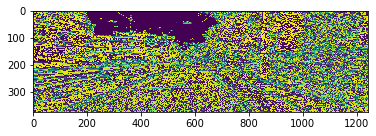

In [145]:
plt.imshow(np.abs(img_dx))

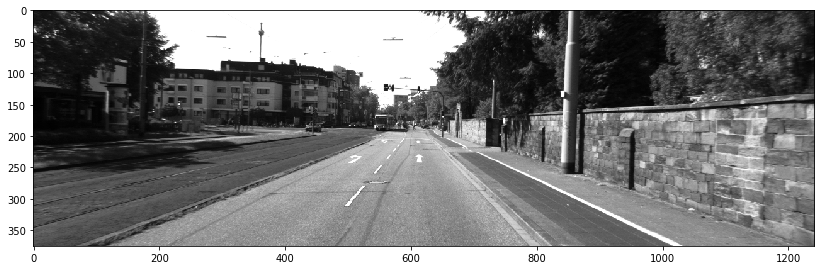

In [123]:
plt.figure(figsize=(14, 10))
plt.imshow(img_gray, cmap=plt.cm.Greys_r);

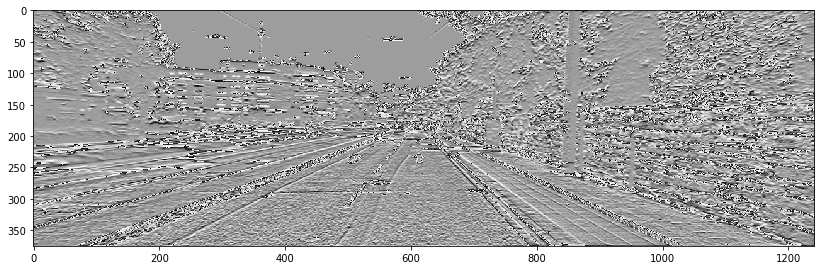

In [140]:
plt.figure(figsize=(14, 10))
plt.imshow(np.abs(img_dx - 122), cmap=plt.cm.Greys_r);

In [296]:
img_w = img_sob.T[img_xy[:, 0], img_xy[:, 1]].astype(float)
w.shape

(18062,)

In [298]:
rel_depth_grads = sob.T[img_xy[:, 0], img_xy[:, 1]]

In [301]:
A = (rel_depth_grads * img_w).sum()

In [303]:
N = img_w.sum() * rel_depth_grads.sum()

In [307]:
F = A / N
F

5.540022503550201e-05

In [310]:
r, t = np.zeros(3), np.zeros(3)

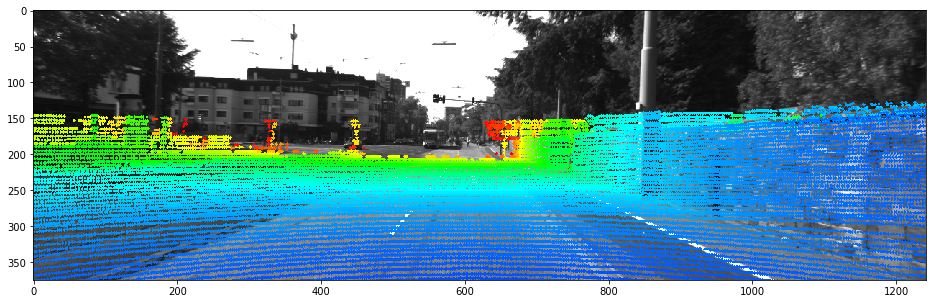

In [318]:
img, pnt, proj, depth = project('2011_09_26/2011_09_26_drive_0002_sync/', '2011_09_26/', frame=59, t_cor=t, r_cor=r)
plt.figure(figsize=(16, 14))
plt.imshow(proj);

In [30]:
def permute(r, t, strategy='all', r_scale=0.01, t_scale=0.01):
    r = np.copy(r)
    t = np.copy(t)
    if strategy == 'all':
        r = r + np.random.randn(3) * r_scale
        t = t + np.random.randn(3) * t_scale
    elif strategy == 'sequential':
        if np.random.rand() < .5:
            r = r + np.random.randn(3) * r_scale
        else:
            t = t + np.random.randn(3) * t_scale
    elif strategy == 'sparse':
        i = np.random.randint(3)
        if np.random.rand() < .5:
            r[i] = r[i] + np.random.randn() * r_scale
        else:
            t[i] = t[i] + np.random.randn() * t_scale
    return r, t

In [217]:
def evaluate(r, t, gamma=0.001):
    """ Obtain F-score for a specific values of parameters r and t """
    img, pnt, proj, depth = project('2011_09_26/2011_09_26_drive_0002_sync/', '2011_09_26/', frame=59, r_cor=r, t_cor=t)
    h, w, c = img.shape
    dimg = np.zeros((h, w))
    ddense = inpaint(pnt, depth, dimg)

    reliable_xy = pnt.round().astype(int).T
    img_idx = np.where((reliable_xy[:, 0] >= 0) & (reliable_xy[:, 0] < w) & (reliable_xy[:, 1] >= 0) & (reliable_xy[:, 1] < h))
    img_xy = reliable_xy[img_idx]
    
    depth_dx, depth_dy, depth_sob = edges(ddense)
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_dx, img_dy, img_sob = edges(img_gray)
    
    dx_w = img_dx.T[img_xy[:, 0], img_xy[:, 1]].astype(float)
    dx_w = np.exp(-gamma * np.abs(dx_w))
    
    rel_depth_grads = depth_dx.T[img_xy[:, 0], img_xy[:, 1]]
    rel_depth_grads = np.abs(rel_depth_grads)
    
    A = 0
    N = 0
    A += (rel_depth_grads * dx_w).sum()
    N += dx_w.sum() * rel_depth_grads.sum()
    
    dy_w = img_dy.T[img_xy[:, 0], img_xy[:, 1]].astype(float)
    dy_w = np.exp(-gamma * np.abs(dy_w))
    
    rel_depth_grads = depth_dy.T[img_xy[:, 0], img_xy[:, 1]]
    rel_depth_grads = np.abs(rel_depth_grads)
    
    A += (rel_depth_grads * dy_w).sum()
    N += dy_w.sum() * rel_depth_grads.sum()
#     A = (rel_depth_grads * img_w).sum()
#     N = img_w.sum() * np.abs(rel_depth_grads).sum()
    F = A / N
    return F

In [218]:
evaluate(r, t)

0.00011782105034523324

In [219]:
best_r, best_t, best_score = r, t, None

In [220]:
permute(r, t)

(array([0.46930289, 0.33773846, 0.21592586]),
 array([ 0.21169934,  0.391928  , -0.29342669]))

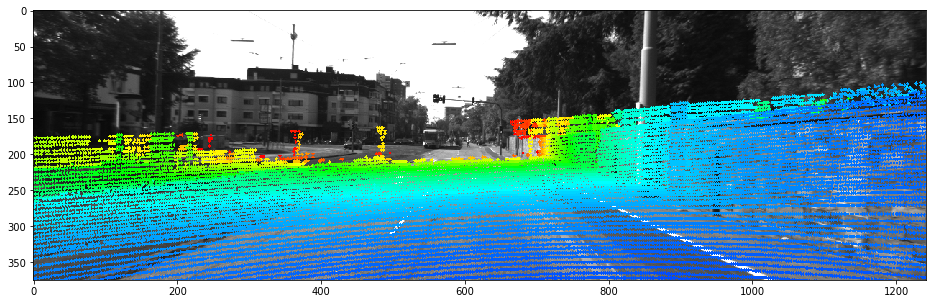

In [221]:
r_bias = np.array([0.05, .05, -.01])
t_bias = np.array([0, 0.01, -0.05])
img, pnt, proj, depth = project('2011_09_26/2011_09_26_drive_0002_sync/', '2011_09_26/', frame=59, t_cor=t_bias, r_cor=r_bias)
plt.figure(figsize=(16, 14))
plt.imshow(proj);

In [222]:
r, t = np.zeros(3), np.zeros(3)
error_log = []
update_log = []
seed = 42
n_iter = 100
prev_score = evaluate(r + r_bias, t + t_bias)
best_score = None
accept_worse = True
np.random.seed(seed)
print(f'[iteration]: R | T | Score')
for temperature in range(1, n_iter + 1):
    r_candidate, t_candidate = permute(r, t, strategy='sparse', r_scale=.01, t_scale=.01)
    score = evaluate(r_candidate + r_bias, t_candidate + t_bias)
    if score < prev_score:
        print(f"Random search improved: {score:.8f} < {prev_score:.8f}")
        print(f'[{temperature}]: {r_candidate} | {t_candidate} | {score}')
        r = r_candidate
        t = t_candidate
        if best_score is None or best_score > score:
            best_score = score
            best_r = r
            best_t = t
            error_log.append(((best_r - r_bias) ** 2 + (best_t - t_bias) ** 2).sum())
            update_log.append(temperature)
        prev_score = score
    elif accept_worse:
        p = np.exp(-(score - prev_score) * 2000000 / temperature)
#         print("Probability:", p)
        if np.random.rand() > p:
            print(f"Accepting worse candidate with P={p} and score={score}")
            r, t = r_candidate, t_candidate
            prev_score = score

best_r, best_t

[iteration]: R | T | Score
Random search improved: 0.00005474 < 0.00005481
[1]: [0. 0. 0.] | [0.         0.         0.00543743] | 5.474055835360362e-05
Random search improved: 0.00005468 < 0.00005474
[2]: [-0.0061543  0.         0.       ] | [0.         0.         0.00543743] | 5.467654821511446e-05
Random search improved: 0.00005452 < 0.00005468
[3]: [-0.0061543   0.         -0.02010963] | [0.         0.         0.00543743] | 5.4522736026331894e-05
Random search improved: 0.00005446 < 0.00005452
[4]: [-0.0061543   0.         -0.02503766] | [0.         0.         0.00543743] | 5.445966149128468e-05
Random search improved: 0.00005445 < 0.00005446
[5]: [-0.0061543   0.         -0.02503766] | [0.         0.00022222 0.00543743] | 5.44526361894643e-05
Random search improved: 0.00005439 < 0.00005445
[6]: [-0.0061543   0.         -0.02931559] | [0.         0.00022222 0.00543743] | 5.4388862121937135e-05
Random search improved: 0.00005430 < 0.00005439
[7]: [-0.0061543   0.         -0.03561034]

(array([-0.01441953, -0.00694386, -0.14079045]),
 array([-0.02589094, -0.05345203,  0.05558694]))

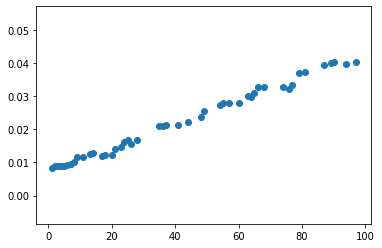

In [223]:
plt.scatter(update_log, error_log);

In [224]:
r_bias = np.array([0.05, .05, -.01])
t_bias = np.array([0, 0.01, -0.05])

In [226]:
best_r, best_t

(array([-0.01441953, -0.00694386, -0.14079045]),
 array([-0.02589094, -0.05345203,  0.05558694]))

In [199]:
r_try = -r_bias
t_try = -t_bias

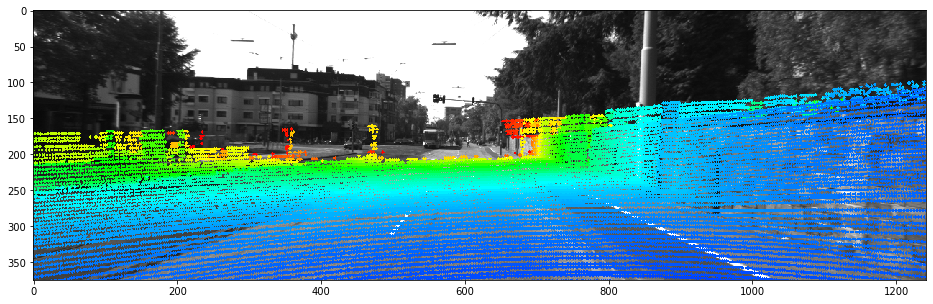

In [227]:
img, pnt, proj, depth = project('2011_09_26/2011_09_26_drive_0002_sync/', '2011_09_26/', frame=59, t_cor=best_t + t_bias, r_cor=best_r + r_bias)
plt.figure(figsize=(16, 14))
plt.imshow(proj);

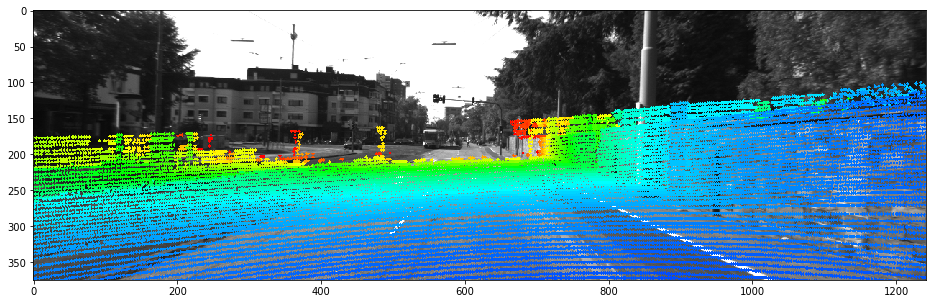

In [195]:
img, pnt, proj, depth = project('2011_09_26/2011_09_26_drive_0002_sync/', '2011_09_26/', frame=59, t_cor=t_bias, r_cor=r_bias)
plt.figure(figsize=(16, 14))
plt.imshow(proj);

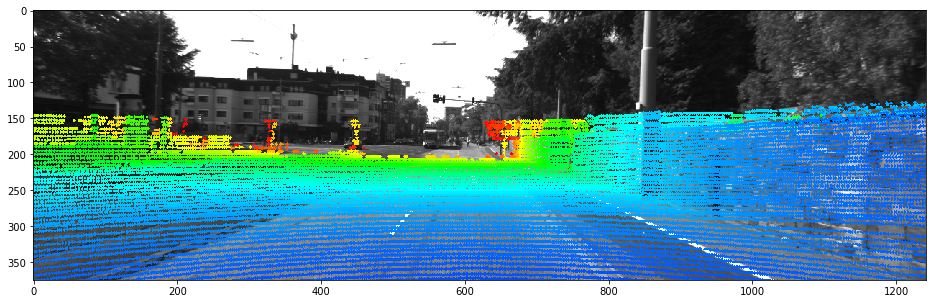

In [498]:
img, pnt, proj, depth = project('2011_09_26/2011_09_26_drive_0002_sync/', '2011_09_26/', frame=59)
plt.figure(figsize=(16, 14))
plt.imshow(proj);